# Text Preprocessing Lab: Hotel Reviews

## Overview

You've recently joined TextInsight, a customer feedback analysis company that helps businesses understand customer sentiments across various platforms. As a junior data scientist, your first project involves preprocessing a dataset of hotel reviews that will be used to build a sentiment analysis model.

The hotel chain wants to identify common issues mentioned in negative reviews and highlight positive experiences that could be promoted in their marketing. Before any analysis can be performed, the raw text data needs to be cleaned and transformed into a structured format suitable for NLP algorithms.

This lab will guide you through implementing a text preprocessing pipeline following these key steps:

- Text Acquisition and Initial Cleaning
- Tokenization and Structural Decomposition
- Normalization and Standardization
- Noise Filtering and Feature Selection
- Feature Extraction and Representation
- Validation and Iterative Refinement

You'll apply these steps to transform messy, unstructured hotel reviews into clean, analyzable data that can reveal meaningful patterns and insights.

## Step 0: Imports and Data

First, run the provided code cell to import the necessary libraries and download required NLTK resources:

In [1]:
# Run this cell without changes
import pandas as pd
import numpy as np
import nltk
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Import specific NLTK modules
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.util import ngrams

# # Download necessary NLTK data
# nltk.download('punkt_tab')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('vader_lexicon')

# Load the hotel reviews dataset
hotel_reviews = pd.read_csv('hotel_reviews.csv')
hotel_reviews.head()

,review_id,hotel_name,review_text,rating,review_date
0,1,Countryside Manor,Just returned from a 1 night stay at Countrysi...,5,2023-01-07
1,2,Riverside Inn,I had a terrible experience at Riverside Inn. ...,2,2023-05-13
2,3,Oceanview Resort,I cannot recommend Oceanview Resort. The break...,1,2022-06-19
3,4,Riverside Inn,Just returned from a week-long night stay at R...,5,2023-12-08
4,5,City Center Suites,City Center Suites has potential but falls sho...,3,2022-05-04


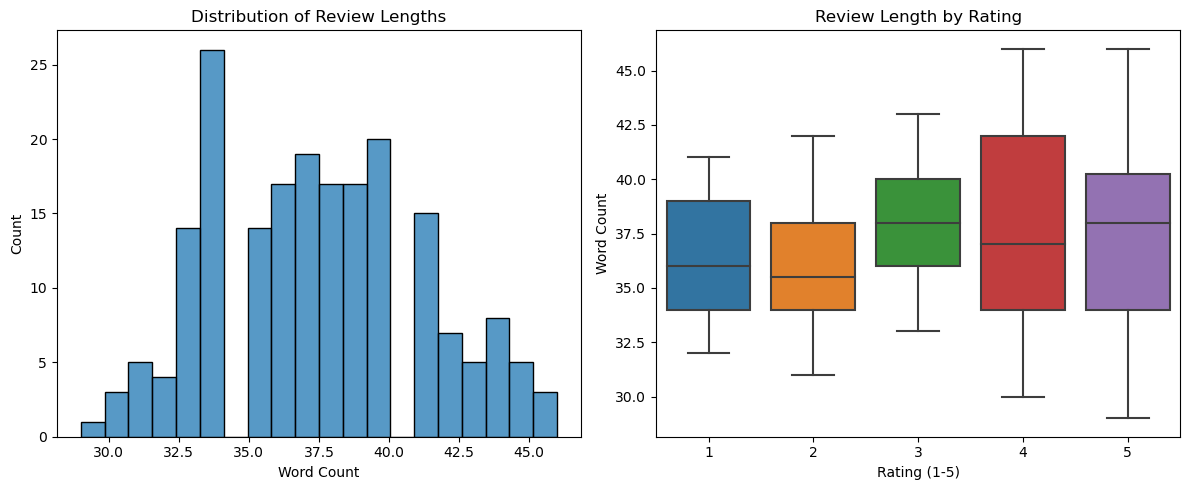

In [2]:
# Run this cell without changes
# Calculate basic text statistics
hotel_reviews['review_length'] = hotel_reviews['review_text'].apply(len)
hotel_reviews['word_count'] = hotel_reviews['review_text'].apply(lambda x: len(str(x).split()))
hotel_reviews['sentence_count'] = hotel_reviews['review_text'].apply(lambda x: len(sent_tokenize(str(x))))

# Create visualizations to understand the data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(hotel_reviews['word_count'], bins=20)
plt.title('Distribution of Review Lengths')
plt.xlabel('Word Count')

plt.subplot(1, 2, 2)
sns.boxplot(x='rating', y='word_count', data=hotel_reviews)
plt.title('Review Length by Rating')
plt.xlabel('Rating (1-5)')
plt.ylabel('Word Count')
plt.tight_layout()
plt.show()

## Step 1: Text Cleaning and Tokenization
Implement functions to clean the text and break it down into analyzable units:

In [3]:

# Tokenize the reviews into sentences and word tokens
hotel_reviews['sentences'] = hotel_reviews['review_text'].fillna('').apply(lambda x: sent_tokenize(str(x)))
hotel_reviews['tokens'] = hotel_reviews['review_text'].fillna('').apply(lambda x: word_tokenize(str(x)))

# Assign the count of unique word tokens across all reviews (before cleaning)
all_tokens = [tok for toks in hotel_reviews['tokens'] for tok in toks]
unique_token_count_pre = len(set(all_tokens))

# Create function to clean initial word tokens
def clean_text(text_tokens):
    """
    Clean raw text by:
    1. Converting to lowercase
    2. Removing HTML tags if present
    3. Removing special characters
    4. Handling common abbreviations

    Parameters:
    text_tokens: list of word tokens

    Returns:
    list: cleaned list of tokens
    """
    if not isinstance(text_tokens, list):
        return []

    # 1) lowercase
    tokens = [t.lower() for t in text_tokens]

    # 2) strip any stray HTML tags within tokens
    tokens = [re.sub(r'<[^>]+>', '', t) for t in tokens]

    # 4) handle common contractions/abbreviations
    # note: since we're already tokenized, we normalize common tokens
    contraction_map = {
        "can't": "can not", "won't": "will not", "n't": "not",
        "'re": "are", "'s": "is", "'d": "would", "'ll": "will",
        "'ve": "have", "'m": "am"
    }
    expanded = []
    for t in tokens:
        if t in contraction_map:
            expanded.extend(contraction_map[t].split())
        else:
            # also split cases like "didn't" if tokenizer kept it as one token
            t = re.sub(r"n['’]t$", " not", t)
            t = re.sub(r"['’]re$", " are", t)
            t = re.sub(r"['’]s$", " is", t)
            t = re.sub(r"['’]d$", " would", t)
            t = re.sub(r"['’]ll$", " will", t)
            t = re.sub(r"['’]ve$", " have", t)
            t = re.sub(r"['’]m$", " am", t)
            expanded.extend(t.split())

    # 3) remove special characters/pure punctuation (keep numbers and alphanumerics)
    cleaned = []
    for t in expanded:
        t = re.sub(r"[^a-z0-9\-]", "", t)  # keep letters, digits, and hyphen
        if t and not all(ch in string.punctuation for ch in t):
            cleaned.append(t)

    return cleaned

# Apply cleaning to all reviews
hotel_reviews['clean_tokens'] = hotel_reviews['tokens'].apply(clean_text)

In [4]:
# Run this cell without changes
# Check results on a sample review
sample_idx = 10  # Review at index 10
print("Original review:")
print(hotel_reviews['review_text'][sample_idx])
print("\nSentences:")
print(hotel_reviews['sentences'][sample_idx])
print("\nTokens (first 20):")
print(hotel_reviews['clean_tokens'][sample_idx][:20])
print("\nUnique Number of Tokens:")
print(unique_token_count_pre)

Original review:
My stay at Heritage Boutique Hotel was absolutely wonderful! The location was exceptional, and the cleanliness exceeded my expectations. The breakfast buffet had an amazing variety of fresh, delicious options. I would definitely recommend this hotel to anyone visiting New Orleans.

Sentences:
['My stay at Heritage Boutique Hotel was absolutely wonderful!', 'The location was exceptional, and the cleanliness exceeded my expectations.', 'The breakfast buffet had an amazing variety of fresh, delicious options.', 'I would definitely recommend this hotel to anyone visiting New Orleans.']

Tokens (first 20):
['my', 'stay', 'at', 'heritage', 'boutique', 'hotel', 'was', 'absolutely', 'wonderful', 'the', 'location', 'was', 'exceptional', 'and', 'the', 'cleanliness', 'exceeded', 'my', 'expectations', 'the']

Unique Number of Tokens:
442


## Step 2: Stopword Removal and Normalization
Filter out common words that add little analytical value and normalize (lemmatize) the remaining tokens:

In [5]:
# nltk.download('omw-1.4')
# nltk.download('wordnet')  # ensure wordnet is also available

# Start with NLTK's English stopwords
stop_words = set(stopwords.words('english'))

# Add domain-specific stopwords common in hotel reviews
domain_stopwords = {
    'hotel', 'room', 'rooms', 'stay', 'stayed', 'staying',
    'staff', 'place', 'night', 'nights', 'day', 'days',
    'breakfast', 'service', 'location', 'floor', 'bed',
    'lobby', 'desk', 'check', 'checkout', 'checkin'
}

# Merge them into one set
stop_words = stop_words.union(domain_stopwords)

# Function to remove stopwords
def remove_stopwords(tokens):
    """
    Remove stopwords from a list of tokens
    """
    if not isinstance(tokens, list):
        return []
    return [t for t in tokens if t not in stop_words]

# Apply stopword removal
hotel_reviews['filtered_tokens'] = hotel_reviews['clean_tokens'].apply(remove_stopwords)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Helper function for lemmatization with POS tagging
def get_wordnet_pos(treebank_tag):
    """
    Convert NLTK POS tags to WordNet POS tags
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Lemmatization function
def lemmatize_tokens(tokens):
    """
    Lemmatize tokens with appropriate POS tags
    """
    if not isinstance(tokens, list):
        return []
    
    # Tag tokens with parts of speech
    tokens_tagged = pos_tag(tokens)
    
    # Convert to WordNet POS tags and lemmatize
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tagged))
                  for word, pos_tagged in tokens_tagged]
    return lemmatized

# Apply lemmatization
hotel_reviews['lemmatized_tokens'] = hotel_reviews['filtered_tokens'].apply(lemmatize_tokens)

# Calculate stopword reduction percentage
all_tokens = []
for tokens in hotel_reviews['lemmatized_tokens']:
    all_tokens.extend(tokens)
unique_token_count_post = len(set(all_tokens))
stopword_reduction_percent = ((unique_token_count_pre - unique_token_count_post) / unique_token_count_pre) * 100

In [6]:
# Run this cell without changes
# Check results on the sample review
print("Tokens after stopword removal (first 15):")
print(hotel_reviews['filtered_tokens'][sample_idx][:15])
print("\nTokens after lemmatization (first 15):")
print(hotel_reviews['lemmatized_tokens'][sample_idx][:15])
print(f"\nRemoving stopwords and lemmatizing the text has reduced the vocaburlary by {stopword_reduction_percent:.2f}%")

Tokens after stopword removal (first 15):
['heritage', 'boutique', 'absolutely', 'wonderful', 'exceptional', 'cleanliness', 'exceeded', 'expectations', 'buffet', 'amazing', 'variety', 'fresh', 'delicious', 'options', 'would']

Tokens after lemmatization (first 15):
['heritage', 'boutique', 'absolutely', 'wonderful', 'exceptional', 'cleanliness', 'exceed', 'expectation', 'buffet', 'amazing', 'variety', 'fresh', 'delicious', 'option', 'would']

Removing stopwords and lemmatizing the text has reduced the vocaburlary by 20.36%


## Step 3: Generate N-grams and Analyze Frequent Terms
Extract word sequences to capture phrases and identify common topics in the reviews:

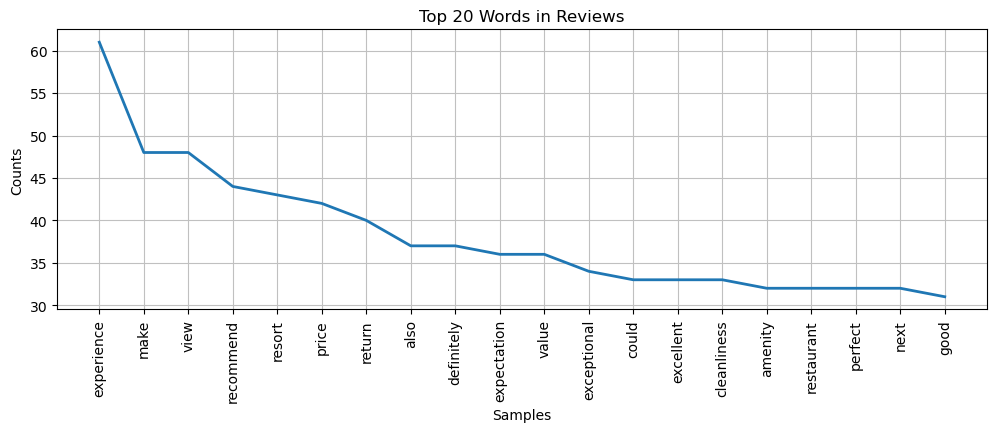

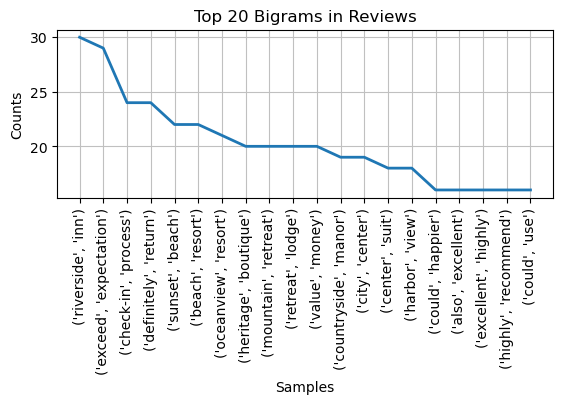

<Figure size 640x480 with 0 Axes>

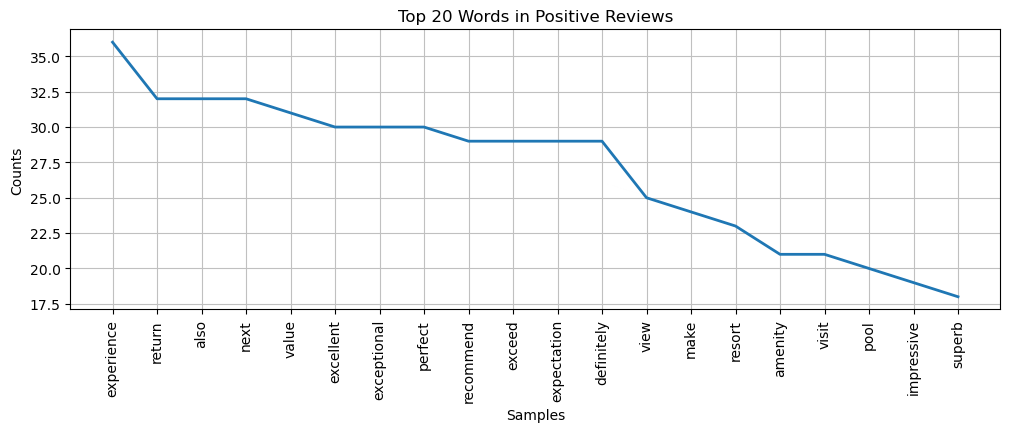

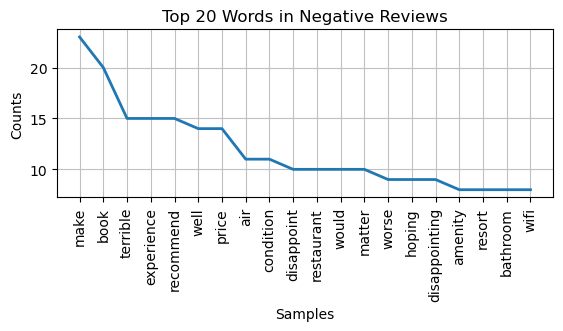

<Figure size 640x480 with 0 Axes>

In [7]:
# Function to generate bigrams and trigrams
def generate_ngrams(tokens, n):
    """
    Generate n-grams from a list of tokens
    """
    if not isinstance(tokens, list) or len(tokens) < n:
        return []
    return list(ngrams(tokens, n))

# Generate bigrams and trigrams - hint - apply lambda function
hotel_reviews['bigrams'] = hotel_reviews['lemmatized_tokens'].apply(lambda toks: generate_ngrams(toks, 2))
hotel_reviews['trigrams'] = hotel_reviews['lemmatized_tokens'].apply(lambda toks: generate_ngrams(toks, 3))

# Combine all lemmatized tokens into a single list for frequency analysis
all_tokens = []
for tokens in hotel_reviews['lemmatized_tokens']:
    all_tokens.extend(tokens)

# Calculate all token frequencies
token_freq = FreqDist(all_tokens)

# Get all bigrams for frequency analysis
all_bigrams = []
for bigrams_list in hotel_reviews['bigrams']:
    all_bigrams.extend(bigrams_list)

# Calculate bigram frequencies
bigram_freq = FreqDist(all_bigrams)

# Visualize top tokens and bigrams
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
token_freq.plot(20, title="Top 20 Words in Reviews")

plt.subplot(2, 1, 2)
bigram_freq.plot(20, title="Top 20 Bigrams in Reviews")
plt.tight_layout()
plt.show()

# Find top tokens and bigrams for positive and negative reviews
# (ensure rating is numeric)
hotel_reviews['rating'] = pd.to_numeric(hotel_reviews['rating'], errors='coerce')

positive_reviews = hotel_reviews[hotel_reviews['rating'] >= 4]
negative_reviews = hotel_reviews[hotel_reviews['rating'] <= 2]

# Collect tokens from positive and negative reviews
positive_tokens = []
for tokens in positive_reviews['lemmatized_tokens']:
    positive_tokens.extend(tokens)

negative_tokens = []
for tokens in negative_reviews['lemmatized_tokens']:
    negative_tokens.extend(tokens)

# Calculate frequencies
positive_freq = FreqDist(positive_tokens)
negative_freq = FreqDist(negative_tokens)

# Visualize top tokens by sentiment
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
positive_freq.plot(20, title="Top 20 Words in Positive Reviews")

plt.subplot(2, 1, 2)
negative_freq.plot(20, title="Top 20 Words in Negative Reviews")
plt.tight_layout()
plt.show()

## Step 4: Apply Sentiment Analysis to Preprocessed Text
Use the preprocessed text to analyze sentiment and compare with the explicit ratings:

In [8]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Join lemmatized tokens back into strings for sentiment analysis
hotel_reviews['lemmatized_text'] = hotel_reviews['lemmatized_tokens'].apply(
    lambda toks: ' '.join(toks) if isinstance(toks, list) else ''
)

# Calculate sentiment scores
hotel_reviews['sentiment_scores'] = hotel_reviews['lemmatized_text'].apply(lambda txt: sia.polarity_scores(txt))
hotel_reviews['sentiment_compound'] = hotel_reviews['sentiment_scores'].apply(lambda d: d['compound'])

# Classify sentiment based on compound score
def classify_sentiment(score):
    """
    Classify sentiment based on compound score
    """
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

hotel_reviews['predicted_sentiment'] = hotel_reviews['sentiment_compound'].apply(classify_sentiment)

# Create a new column that compares the predicted sentiment with the actual rating
def compare_sentiment_with_rating(row):
    """
    Compare predicted sentiment with rating
    """
    # Convert rating to sentiment category
    actual_sentiment = 'positive' if row['rating'] >= 4 else ('negative' if row['rating'] <= 2 else 'neutral')
    # Compare with predicted sentiment
    if row['predicted_sentiment'] == actual_sentiment:
        return 'match'
    else:
        return 'mismatch'

hotel_reviews['sentiment_match'] = hotel_reviews.apply(compare_sentiment_with_rating, axis=1)

# Calculate sentiment accuracy
sentiment_accuracy = (hotel_reviews['sentiment_match'] == 'match').mean() * 100

# Analyze mismatches
mismatches = hotel_reviews[hotel_reviews['sentiment_match'] == 'mismatch']
mismatches_by_rating = mismatches['rating'].value_counts().sort_index()
mismatches_by_rating

1     7
2     6
3    54
Name: rating, dtype: int64

## Step 5: Evaluate the Preprocessing Pipeline
Analyze how your preprocessing choices affected the results:

In [9]:
# Create a function to measure vocabulary size at each step
def calculate_vocabulary_sizes(df):
    """
    Calculate vocabulary size at each preprocessing step
    """
    original_vocab = set()
    filtered_vocab = set()
    lemmatized_vocab = set()
    
    # Original tokens
    if 'tokens' in df.columns:
        for toks in df['tokens']:
            if isinstance(toks, list):
                original_vocab.update(toks)
            elif isinstance(toks, str):
                original_vocab.update(toks.split())

    # After stopword removal
    if 'filtered_tokens' in df.columns:
        for toks in df['filtered_tokens']:
            if isinstance(toks, list):
                filtered_vocab.update(toks)
            elif isinstance(toks, str):
                filtered_vocab.update(toks.split())

    # After lemmatization
    if 'lemmatized_tokens' in df.columns:
        for toks in df['lemmatized_tokens']:
            if isinstance(toks, list):
                lemmatized_vocab.update(toks)
            elif isinstance(toks, str):
                lemmatized_vocab.update(toks.split())
    
    return {
        'original': len(original_vocab),
        'filtered': len(filtered_vocab),
        'lemmatized': len(lemmatized_vocab)
    }

vocab_sizes = calculate_vocabulary_sizes(hotel_reviews)

# Calculate token reduction percentages
orig = vocab_sizes['original']
filt = vocab_sizes['filtered']
lemm = vocab_sizes['lemmatized']

original_to_filtered = ((orig - filt) / orig * 100) if orig else 0.0
filtered_to_lemmatized = ((filt - lemm) / filt * 100) if filt else 0.0
total_reduction = ((orig - lemm) / orig * 100) if orig else 0.0

Original vocabulary size: 442 unique tokens
After stopword removal: 345 unique tokens (21.9% reduction)
After lemmatization: 352 unique tokens (-2.0% further reduction)
Total vocabulary reduction: 20.4%


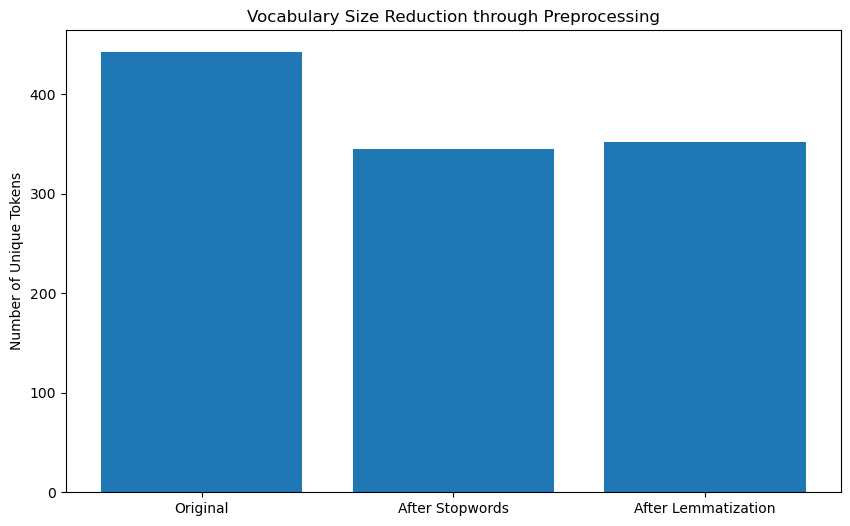

In [10]:
# Run this cell without changes
# Summarize vocabulary size changes
print(f"Original vocabulary size: {vocab_sizes['original']} unique tokens")
print(f"After stopword removal: {vocab_sizes['filtered']} unique tokens ({original_to_filtered:.1f}% reduction)")
print(f"After lemmatization: {vocab_sizes['lemmatized']} unique tokens ({filtered_to_lemmatized:.1f}% further reduction)")
print(f"Total vocabulary reduction: {total_reduction:.1f}%")

# Create a bar chart showing vocabulary size reduction
plt.figure(figsize=(10, 6))
plt.bar(['Original', 'After Stopwords', 'After Lemmatization'], 
        [vocab_sizes['original'], vocab_sizes['filtered'], vocab_sizes['lemmatized']])
plt.title('Vocabulary Size Reduction through Preprocessing')
plt.ylabel('Number of Unique Tokens')
plt.show()